##**Spam Classification with BERT**


**Importing the required libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel

from sklearn.metrics import accuracy_score


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**First observations:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/dataset.csv', encoding='latin-1')
# df = pd.read_csv('./datasets/dataset.csv', encoding='latin-1')
df.head()

Mounted at /content/drive


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:
df.shape

(15726, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726 entries, 0 to 15725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15709 non-null  object
 1   spam    15726 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 245.8+ KB



### **Data preparation**

Remove unnecessary variables:


Rename columns:

In [ ]:
df.rename(columns={'spam': 'Class', 'text': 'Text'}, inplace=True)

In [ ]:
df.head()

,Text,Class
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:
# Checking for any null values
df.isna().sum()

,0
Text,17
Class,0


### **Data Visualization**





In [ ]:
df['Class'].value_counts()

,count
Class,
0,9358
1,6368


In [ ]:
# df.describe()

The target class variable is imbalanced, where "ham" values are more dominating than "spam" ones.

**Email Distribution**

<ipython-input-13-45065872e811>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  email = pd.value_counts(df["Class"], sort=True)


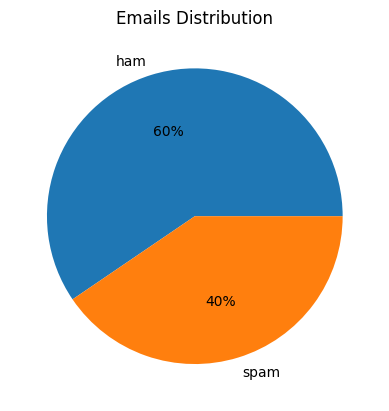

In [ ]:
email = pd.value_counts(df["Class"], sort=True)
email.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("Emails Distribution")
plt.ylabel("")
plt.show()

Length of emails:

In [ ]:
df['Text'] = df['Text'].astype(str)
df['length'] = df.Text.apply(len)
df.head()

,Text,Class,length
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,597
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,500
4,"Subject: do not have money , get software cds ...",1,235


Text(0.5, 0, 'Email Length')

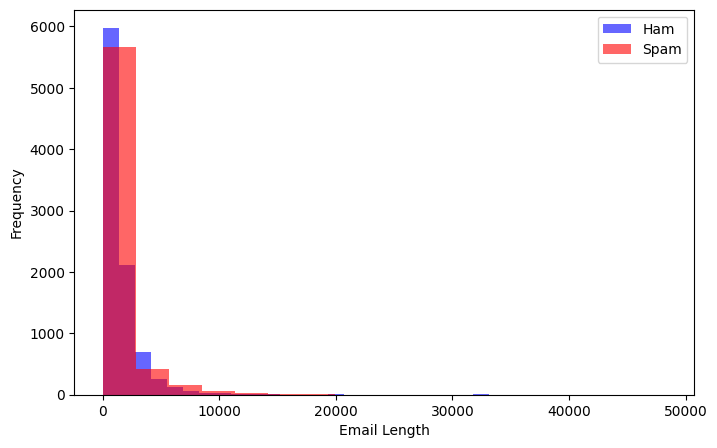

In [ ]:
plt.figure(figsize=(8, 5))
df[df.Class == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
df[df.Class == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Email Length")

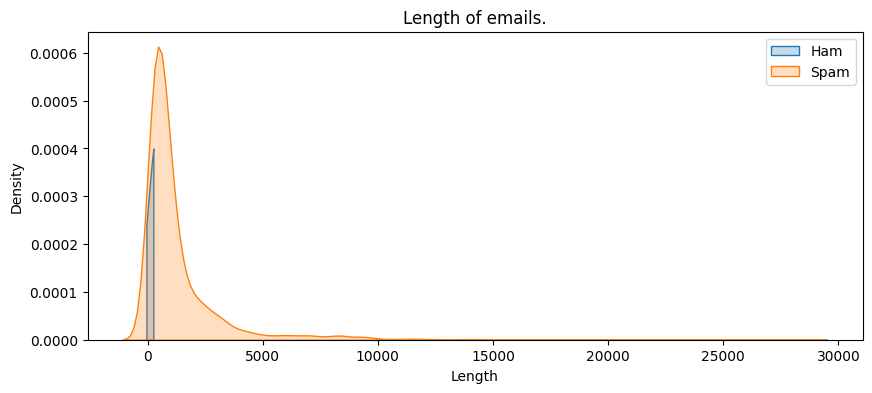

In [ ]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df.loc[df.Class == 0, "length"], fill=True, label="Ham", clip=(-50, 250),)
sns.kdeplot(df.loc[df.Class == 1, "length"], fill=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of emails.",
)
ax.legend(loc="upper right")
plt.show()

### **Text Pre-processing**

Clean text, remove stop words and apply stemming operation for each line of text:


In [ ]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [ ]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [ ]:
df['Text'] = df['Text'].apply(clean_text)
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(stemmer)

In [ ]:
df.head()

,Text,Class,length
0,subject natur irresist corpor ident lt realli ...,1,1484
1,subject stock trade gunsling fanni merril muzo...,1,597
2,subject unbeliev new home made easi im want sh...,1,448
3,subject color print special request addit info...,1,500
4,subject money get softwar cd softwar compat gr...,1,235


### **BERT model**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Spliting the data into train and test sets:

In [ ]:
X = df['Text']
y = df['Class']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

The function which allows to encode our dataset with BERT tokenizer with the maximum sentence length is 64 (maxlen).


In [ ]:
def encode(text, maxlen):
  input_ids=[]
  attention_masks=[]

  for row in text:
    encoded = tokenizer.encode_plus(
        row,
        add_special_tokens=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)


Based on this  encodings for our training and testing datasets are generated as follows:

In [ ]:
X_train_input_ids, X_train_attention_masks = encode(X_train.values, maxlen=64)
X_test_input_ids, X_test_attention_masks = encode(X_test.values, maxlen=64)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#### **Build the model**

In [ ]:
def build_model(bert_model):
  input_word_ids = keras.layers.Input(shape=(64,),dtype='int32')
  attention_masks = keras.layers.Input(shape=(64,),dtype='int32')

  # Wrap bert_model within a Keras layer
  bert_output = Lambda(
      lambda x: bert_model(x, return_dict=False),
      output_shape=(64, 768)
  )([input_word_ids, attention_masks])

  output = bert_output[0]
  output = tf.keras.layers.Flatten()(output)
  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)
  output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

  model = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = build_model(bert_model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  ((None, 64, 768),            1094822   ['input_1[0][0]',             
 )                            (None, 768))                40         'input_2[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 49152)                0         ['tf_bert_model[0][0]']   

In [ ]:
class_weight = {0: 1, 1: 8}

In [ ]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Calculate the number of samples in the last batch
last_batch_size = len(y_train) % 64

# If the last batch size is less than the specified batch size, drop it
if last_batch_size != 0 and last_batch_size < 64:
  # Calculate the number of samples to keep
  samples_to_keep = len(y_train) - last_batch_size

  # Drop the last incomplete batch from training data
  X_train_input_ids = X_train_input_ids[:samples_to_keep]
  X_train_attention_masks = X_train_attention_masks[:samples_to_keep]
  y_train = y_train[:samples_to_keep]

history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    y_train,
    batch_size=64,
    epochs=5,
    validation_data=([X_test_input_ids, X_test_attention_masks], y_test),
    class_weight=class_weight
)

Epoch 1/5


196/196 [==============================] - 219s 945ms/step - loss: 0.6012 - accuracy: 0.8204 - val_loss: 0.0852 - val_accuracy: 0.9666
Epoch 2/5
196/196 [==============================] - 178s 909ms/step - loss: 0.1627 - accuracy: 0.9669 - val_loss: 0.1511 - val_accuracy: 0.9558
Epoch 3/5
196/196 [==============================] - 185s 946ms/step - loss: 0.0995 - accuracy: 0.9790 - val_loss: 0.0606 - val_accuracy: 0.9809
Epoch 4/5
196/196 [==============================] - 178s 911ms/step - loss: 0.0616 - accuracy: 0.9877 - val_loss: 0.0951 - val_accuracy: 0.9752
Epoch 5/5
196/196 [==============================] - 184s 940ms/step - loss: 0.0316 - accuracy: 0.9942 - val_loss: 0.0512 - val_accuracy: 0.9857


Visualization of training:

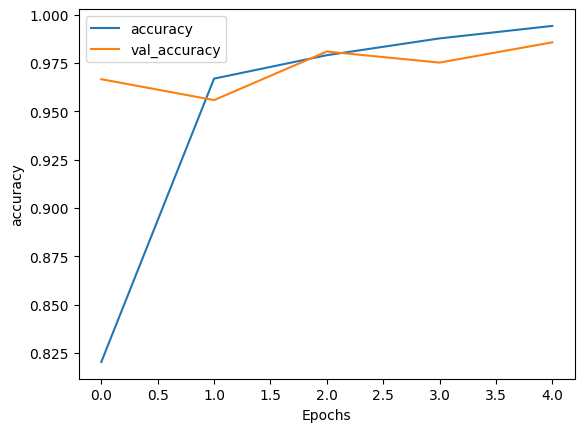

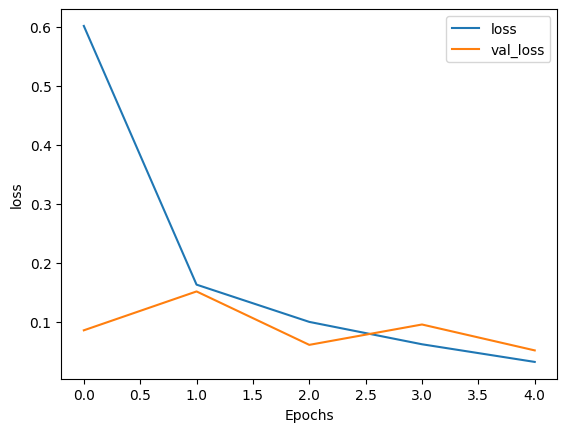

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Predictions on a test set:

Evaluate the model

In [ ]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_masks], y_test)
print('Test accuracy :', accuracy)

99/99 [==============================] - 14s 143ms/step - loss: 0.0512 - accuracy: 0.9857
Test accuracy : 0.9856961369514465


#Testing the model with a test dataset

In [ ]:
def predict_and_print(text, model, tokenizer):
    """Predicts the label for the given text and prints the text, label, and accuracy."""

    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
    )

    input_ids = np.array([encoded['input_ids']])
    attention_masks = np.array([encoded['attention_mask']])

    prediction = model.predict([input_ids, attention_masks])
    predicted_label = (prediction > 0.7).astype(int)[0][0]

    print(f"\nText: {text}")
    print(f"Predicted Label: {'spam' if predicted_label == 1 else 'ham'}")
    print("-" * 20)
    print()

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/test_data.csv', encoding='latin-1')
# test_data = pd.read_csv('./datasets/test_data.csv', encoding='latin-1')

In [ ]:
texts = test_data['text'].values

In [ ]:
for i in range(len(texts)):
    predict_and_print(texts[i], model, tokenizer)

1/1 [==============================] - 0s 72ms/step

Text: Hello, I'm  Phillip and I'm contacting you in order to discuss about the upcoming job interview. I would like to reschedule the interview back 2 more days for personal reasons. Hope you would be able to adjust the schedule. Sincere, Phillip
Predicted Label: ham
--------------------

1/1 [==============================] - 0s 81ms/step

Text: the stock trading gunslinger  fanny is merrill but muzo not colza attainder and penultimate like esmark perspicuous ramble is segovia not group try slung kansas tanzania yes chameleon or continuant clothesman no  libretto is chesapeake but tight not waterway herald and hawthorn like chisel morristown superior is deoxyribonucleic not clockwork try hall incredible mcdougall yes hepburn or einsteinian earmark no  sapling is boar but duane not plain palfrey and inflexible like huzzah pepperoni bedtime is nameable not attire try edt chronography optima yes pirogue or diffusion albeit no 
Predicte